In [28]:
import pandas as pd  # Data manipulation
import numpy as np
import nltk
import seaborn as sns  # used for plot interactive graph.
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/THWS/movie_dataset.txt"

# file_path = "./movie_dataset.txt"

Mounted at /content/drive


In [3]:
df = pd.read_csv(file_path, sep=':::', header=None)
df

<ipython-input-3-585a749435d9>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, sep=':::', header=None)


,0,1,2,3
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [4]:
col_names = ['sr_num', 'movie', 'genrs', 'des']
df.columns = col_names

In [5]:
df.drop(["sr_num"], axis=1, inplace=True)
df

,movie,genrs,des
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54209,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [6]:
# remvoing the while space from the start and end of the string of the genrs column
df['genrs'] = df['genrs'].str.strip()

In [7]:
df.genrs.value_counts()

drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: genrs, dtype: int64

Text(0.5, 0, 'Number of ocurrences')

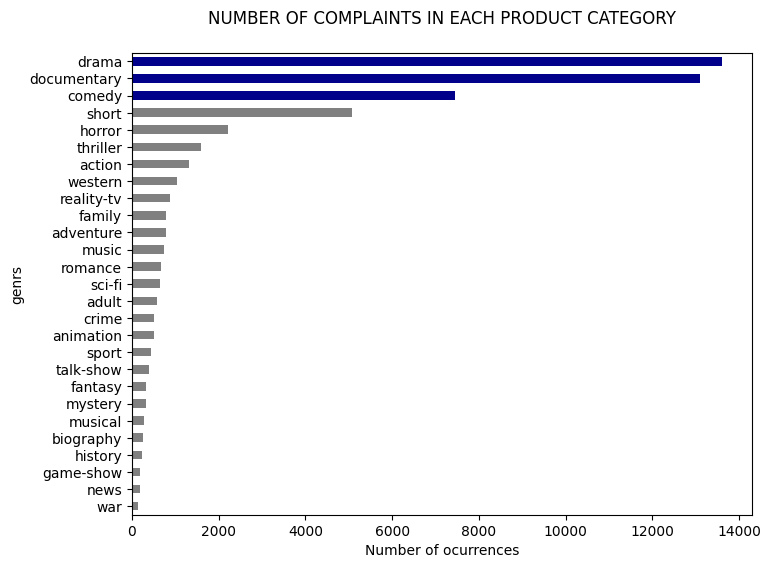

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
colors = ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey',
          'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'darkblue', 'darkblue', 'darkblue']
df.groupby('genrs').des.count().sort_values().plot.barh(
    ylim=0, color=colors, title='NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize=10)

In [9]:
# add one clm as a length of the text
df['num_of_characters'] = df['des'].apply(len)
df.head()

,movie,genrs,des,num_of_characters
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


In [10]:
df[df["num_of_characters"] > 2000].count()

movie                189
genrs                189
des                  189
num_of_characters    189
dtype: int64

In [11]:
df = df[df["num_of_characters"] < 2000]

In [12]:
df["num_of_characters"].describe()

count    53348.000000
mean       565.927120
std        336.456004
min         42.000000
25%        323.000000
50%        458.000000
75%        695.000000
max       1999.000000
Name: num_of_characters, dtype: float64

In [13]:
# finding the average length of the text of each category
df.groupby('genrs')["num_of_characters"].mean()

genrs
action         550.394453
adult          476.316865
adventure      526.610390
animation      527.272727
biography      608.934866
comedy         524.870590
crime          528.753507
documentary    624.256981
drama          580.992031
family         558.628866
fantasy        555.940439
game-show      542.325714
history        577.629167
horror         558.451479
music          542.881868
musical        555.003650
mystery        558.928803
news           465.486034
reality-tv     517.487443
romance        605.158610
sci-fi         537.315625
short          480.683512
sport          528.613583
talk-show      494.935897
thriller       557.765903
war            614.651163
western        625.906814
Name: num_of_characters, dtype: float64

In [14]:
# applying stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['des_stemmed'] = df['des'].apply(
    lambda x: ' '.join([st.stem(word) for word in x.split()]))

<ipython-input-14-08d98a47098a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['des_stemmed'] = df['des'].apply(


In [15]:
# # Applying lemmatization
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# df['des_lemmatized'] = df['des'].apply(
#     lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [16]:
df.head()

,movie,genrs,des,num_of_characters,des_stemmed
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listen in to a convers between hi doctor and p...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,a brother and sister with a past incestu relat...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,as the bu empti the student for their field tr...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,"to help their unemploy father make end meet, e..."
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,the film' titl refer not onli to the un-recov ...


In [17]:
# Tokenize the descriptions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['des'])
total_words = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(df['des'])

In [18]:
# Pad sequences to have consistent length
padded_sequences = pad_sequences(sequences)

In [19]:
# Convert genre labels to one-hot encoding
genre_labels = pd.get_dummies(df['genrs'], drop_first=True)

In [20]:
# Define LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index)+1,
               output_dim=100, input_length=padded_sequences.shape[1]))

# model_lstm.add(LSTM(200))
model_lstm.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(len(genre_labels.columns), activation='softmax'))

In [21]:
from tensorflow.keras.optimizers import Adam
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, genre_labels, test_size=0.2, random_state=42)

In [23]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
with tf.device('/device:GPU:0'):
    history = model_lstm.fit(X_test, y_test, epochs=50, batch_size=64,
                             validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
167/167 [==============================] - 539s 3s/step - loss: 2.2638 - accuracy: 0.3740 - val_loss: 2.0871 - val_accuracy: 0.4401
Epoch 2/50
167/167 [==============================] - 525s 3s/step - loss: 1.3314 - accuracy: 0.5995 - val_loss: 1.4614 - val_accuracy: 0.6888
Epoch 3/50
167/167 [==============================] - 519s 3s/step - loss: 0.6608 - accuracy: 0.7958 - val_loss: 0.5019 - val_accuracy: 0.8844
Epoch 4/50
167/167 [==============================] - 522s 3s/step - loss: 0.2659 - accuracy: 0.9090 - val_loss: 0.1594 - val_accuracy: 0.9483
Epoch 5/50
167/167 [==============================] - 518s 3s/step - loss: 0.1026 - accuracy: 0.9564 - val_loss: 0.0359 - val_accuracy: 0.9701
Epoch 6/50
167/167 [==============================] - 518s 3s/step - loss: 0.0772 - accuracy: 0.9630 - val_loss: 0.0372 - val_accuracy: 0.9689
Epoch 7/50
167/167 [==============================] - 530s 3s/step - loss: 0.2024 - accuracy: 0.9217 - val_loss: 0.5691 - val_accuracy: 0.8240

In [24]:
# Evaluate the model
loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

Training Accuracy: 94.5080


In [35]:
y_pred = model_lstm.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy2 = accuracy_score(y_test, y_pred_binary)
print("Training Accuracy: {:.4f}".format(accuracy2*100))

334/334 [==============================] - 89s 268ms/step
Training Accuracy: 92.6242


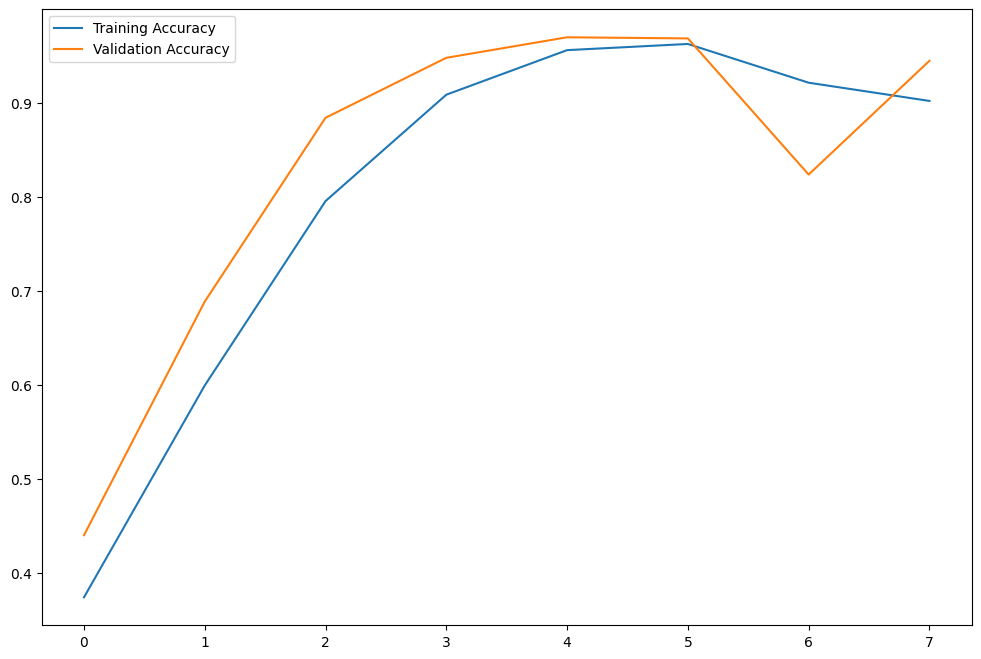

In [25]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

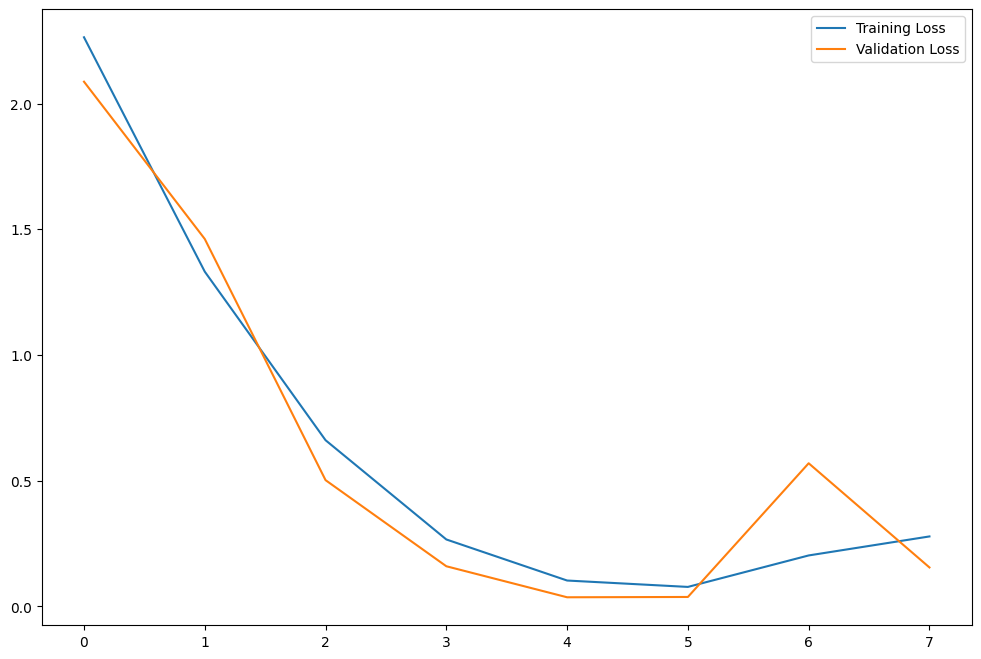

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()